In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.5.1/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetA_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetA_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lon_Bins = Create_Bins(-100,20,5)
Lat_Bins = Create_Bins(0,60,5)

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Function For Creating Cumulative Distribution
def Cum_Dist(Array, Ascend):
    Array = Array[Array > -728]
    if Ascend == True:
        Sorted = numpy.sort(Array)
    else:
        Sorted = numpy.sort(Array)[::-1]
    Len = len(Sorted)
    Density = numpy.arange(0,1.0000001,1/(Len-1))
    return (Sorted, Density)

In [11]:
# Create Function to Plot ET Cumulative Distributions
def ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, Var, Ascend, Horiz, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,8))
#
# Plot ET Initiation
    Axis = Fig.add_subplot(1,2,1)
    Var1 = "ET Begin " + Var
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_ET[Var1], Ascend)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_ET[Var1], Ascend)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_ET[Var1], Ascend)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Var, Horiz, "ET Begin ")
#
# Legend
    pyplot.legend(loc=4, fontsize=15)
#
# Plot ET Completion
    Axis = Fig.add_subplot(1,2,2)
    Var2 = "ET Complete " + Var
# Apply Cumulative Distribution Function
    Control_Sorted, Control_Density = Cum_Dist(Control_ET[Var2], Ascend)
    RCP45_Sorted, RCP45_Density = Cum_Dist(RCP45_ET[Var2], Ascend)
    RCP85_Sorted, RCP85_Density = Cum_Dist(RCP85_ET[Var2], Ascend)
# Plotting
    if Horiz == False:
        Axis.plot(Control_Sorted, Control_Density, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Sorted, RCP45_Density, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Sorted, RCP85_Density, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
    else:
        Axis.plot(Control_Density, Control_Sorted, color='limegreen', linewidth=3.8, label='Control', alpha=0.8)
        Axis.plot(RCP45_Density, RCP45_Sorted, color='orange', linewidth=3.8, label='RCP45', alpha=0.8)
        Axis.plot(RCP85_Density, RCP85_Sorted, color='red', linewidth=3.8, label='RCP85', alpha=0.8)
# Formatting Based on Variable
    ET_Cum_Dist_Formatting(Var, Horiz, "ET Complete ")
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [12]:
# Formatting Based on Variable
def ET_Cum_Dist_Formatting(Var, Horiz, Title1):
# x Ticks and Lims
    if Var == "Lat":
        Min, Max, Width = 10, 60, 5
    elif Var == "Lon":
        Min, Max, Width = -100, 0, 10
    elif Var == "SLP":
        Min, Max, Width = 900, 1010, 10
    x_Ticks = Create_Bins(Min, Max, Width)
#
# y Ticks and Lims
    if Horiz == False:
        pyplot.xticks(x_Ticks)
        pyplot.xlim(Min, Max)
        pyplot.yticks(Create_Bins(0,1,0.125))
        pyplot.ylim(0,1)
    else:
        pyplot.yticks(x_Ticks)
        pyplot.ylim(Min, Max)
        pyplot.xticks(Create_Bins(0,1,0.125))
        pyplot.xlim(0,1)
#
# Labels and Title
    if Var == "Lat":
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel("Latitude", fontsize=18)
    elif Var == "Lon":
        pyplot.ylabel("Cumulative Frequency Density", fontsize=18)
        pyplot.xlabel("Longitude", fontsize=18)
    elif Var == "SLP":
        pyplot.xlabel("Cumulative Frequency Density", fontsize=18)
        pyplot.ylabel("Sea Level Pressure (SLP)", fontsize=18)
    Title = Title1 + Var
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

In [13]:
# Plot Cumulative Density Functions

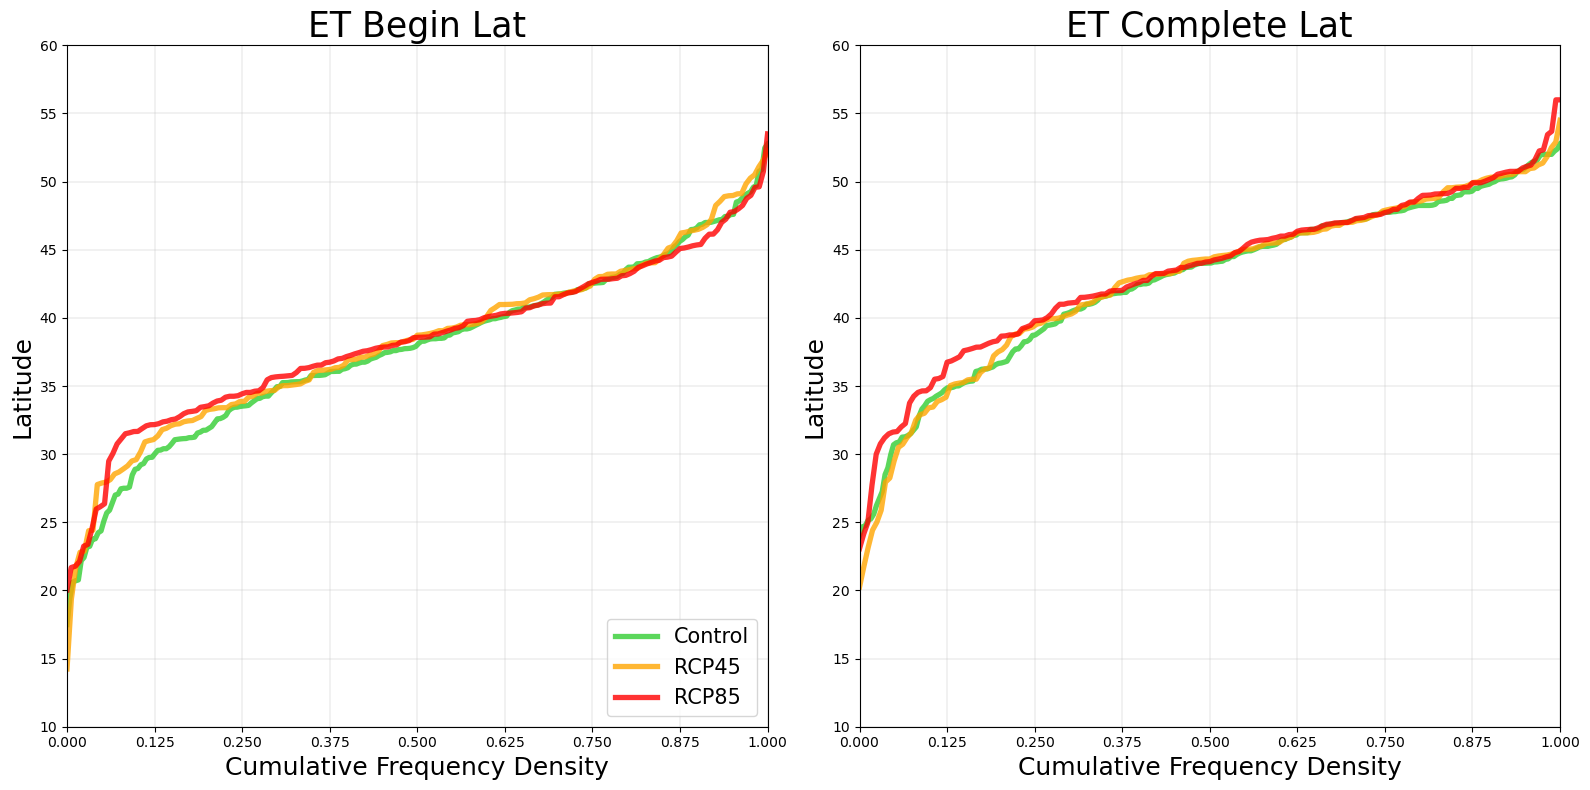

In [14]:
# ET Initiation and Completion Latitude
ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, "Lat", True, True, True, 'ET_Latitude_Cumulative.png')

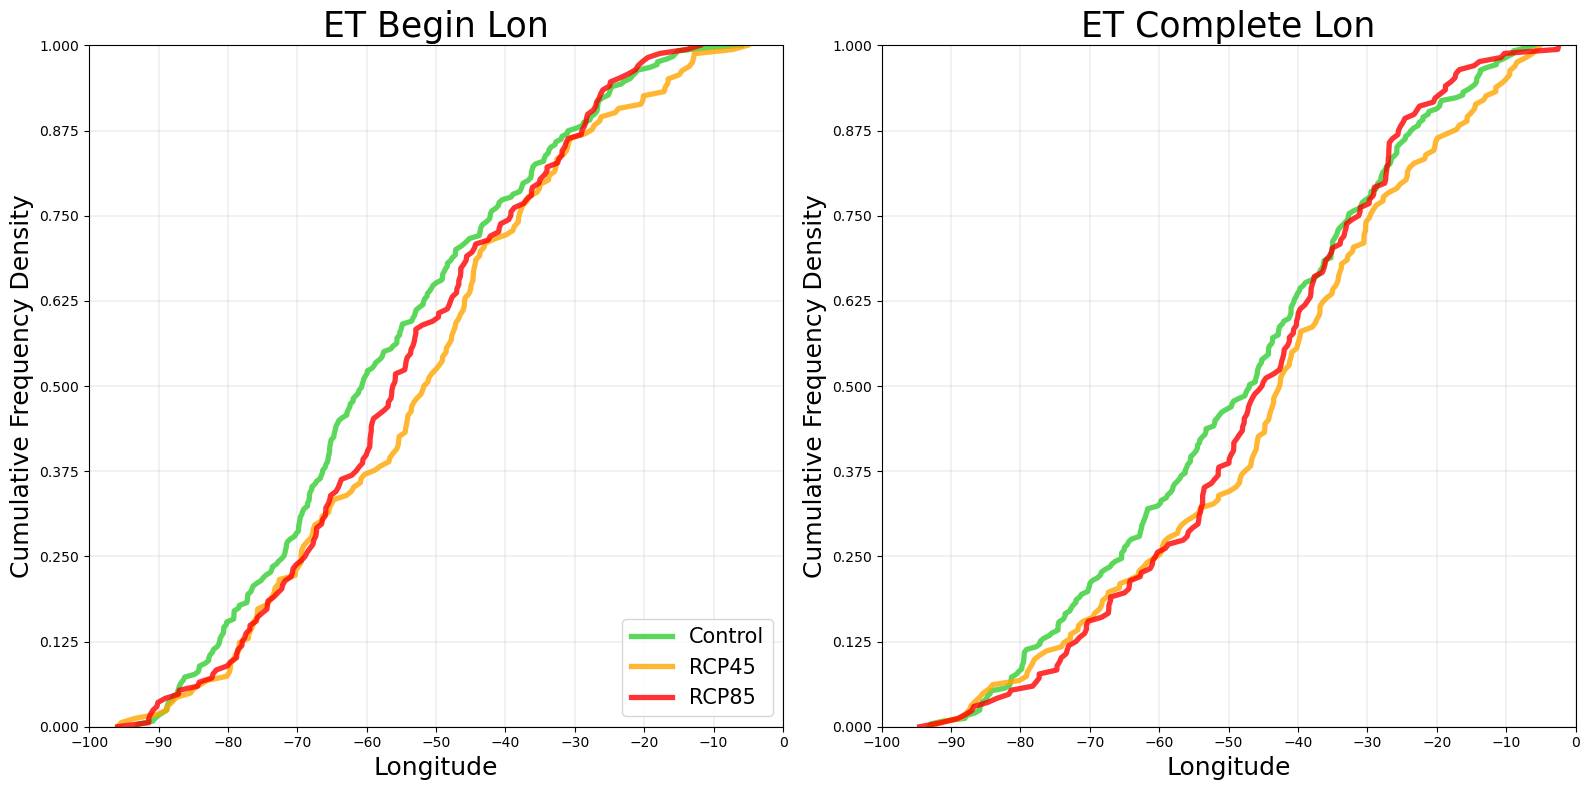

In [15]:
# ET Initiation and Completion Longitude
ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, "Lon", True, False, True, 'ET_Longitude_Cumulative.png')

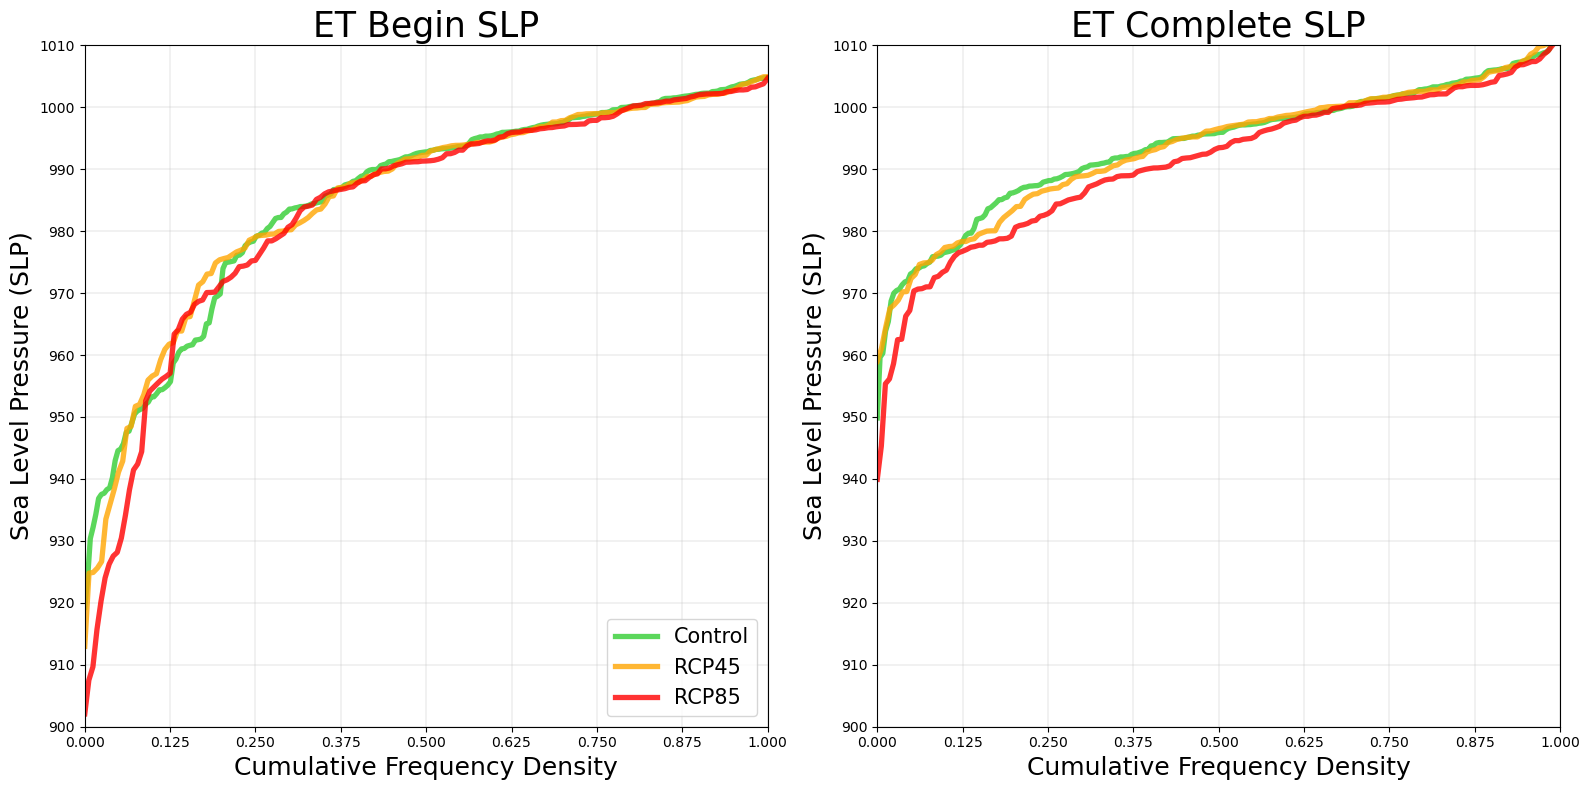

In [16]:
# ET Initiation and Completion Sea Level Pressure
ET_Cum_Dist_Plot(Control_ET, RCP45_ET, RCP85_ET, "SLP", True, True, True, 'ET_SLP_Cumulative.png')